# ДЗ №1. Пухкало В.

## Задание + пресеты

!!!  Все считаем на 1000 итерациях


### Дизайн теста бутстреп
1. Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

2. Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (2 балла)

3. На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (3 балла за расчет + 2 балла за подроброе объяснение)

4. Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (3 балла)


### Дизайн продолжение

1. Посчитать аналогичный дизайн для:
  - бутстреп + логарифмированная метрика длительности просмотров (4 балла)
  - манна-уитни + метрика длительности просмотров (4 балла)
  - манна-уитни + логарифмированная метрика длительности просмотров (4 балла)
  - t-test + метрика длительности просмотров (4 балла)
  - t-test + логарифмированная метрика длительности просмотров (4 балла)
2. Подробно описать выводы для каждой пары, какие варианты точно не подходят и почему. Объяснить зачем мы логарифмируем метрику и что нам это дает. Аргументированно выбрать 1 пару (метрика + критерий) которым вы будете оценивать АБ тест и какой эффект мы сможем отловить в нашем тесте. (5 баллов)


### A/B тест
1) Представим что у нас прошел тест, используем те же самые данные за 2 недели

2) Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (2 балла)

3) Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (1 балла)

4) Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (2 балла)

5) Посчитайте результат такого теста и сделайте выводы (10 баллов)





In [44]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
import datetime
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections

In [45]:
import requests

# download dataset by chunks
url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"

req = requests.get(url, stream=True)

with open('data_kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download: 100%|██████████| 78.8M/78.8M [2:58:52<00:00, 7.34kiB/s]
kion dataset download:  98%|█████████▊| 77.6M/78.8M [00:00<00:00, 185MiB/s]

In [46]:
import zipfile

with zipfile.ZipFile('data_kion.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [47]:
interactions = pd.read_csv('data_kion/interactions_df.csv')
users = pd.read_csv('data_kion/users.csv')
items = pd.read_csv('data_kion/items.csv')

kion dataset download: 100%|██████████| 78.8M/78.8M [00:20<00:00, 185MiB/s]

## Дизайн теста бутстреп

In [48]:
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).dt.date

start_date = datetime.date(2021, 8, 9)
end_date   = datetime.date(2021, 8, 22)

last14 = interactions[
    (interactions['last_watch_dt'] >= datetime.date(2021,8,9))
    & (interactions['last_watch_dt'] <= datetime.date(2021,8,22))
].copy()

In [49]:
last14_agg = last14.groupby('user_id', as_index=False)['total_dur'].sum()
print(f"Кол-во пользователей за 2 недели: {last14_agg['user_id'].nunique():,}")

Кол-во пользователей за 2 недели: 266,081


In [13]:
last14_agg.head()

,user_id,total_dur
0,1,21172
1,3,64654
2,9,108
3,12,5929
4,14,10324


In [50]:
def salt_generator():
    """Генерирует случайную соль (Base64), 8 байт"""
    import os
    from base64 import b64encode
    salt = os.urandom(8)
    return b64encode(salt).decode('ascii')

In [51]:
def groups_splitter(df, columns, user_salt=None):
    """
    Разбивает пользователей на две группы на основе хэша user_id + соль.
    Возвращает df[columns] с колонкой group = {A, B}.
    """
    if user_salt is None:
        user_salt = salt_generator()

    df = df.copy()  # во избежание SettingWithCopyWarning
    df['hash'] = (df['user_id'].astype(str) + '#' + user_salt).apply(
        lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest()
    )
    df['group'] = (
        df['hash'].str.slice(start=-6)
        .apply(int, base=16) % 2
    ).map(lambda x: 'A' if x == 0 else 'B')

    return df[columns].drop_duplicates()

Теперь пишем бутстрап. Надо брать случайную выборку с возвращением, считать среднее и сохранять

In [52]:
def get_bootstrap_array(arr):
    """Создаёт выборку с возвращением размера len(arr)"""
    return np.random.choice(arr, replace=True, size=len(arr))

In [53]:
def calc_bootstrap_mean(arr, size=1000):
    """Считает среднее по бутстрапу size раз"""
    result = np.empty(size)
    for i in range(size):
        sample = get_bootstrap_array(arr)
        result[i] = sample.mean()
    return result

In [54]:
def get_p_value(diff_array):
    """Считаем долю случаев, когда diff_array > 0,
       затем двустороннее p-value."""
    arr = np.array(diff_array)
    prob_positive = (arr > 0).mean()
    p_value = min(prob_positive, 1 - prob_positive) * 2
    return p_value

### Корректность

Оцениваем корректность. Что для этого делаем:
- Считаем бутстрап для двух одинаковых выборок
- Строим распределение разниц средних (A - B) и смотрим 95% доверительный интервал
- По идее разницы между выборками быть не должно поэтому 0 должен попасть в интервал
- Запускаем 1000 раз и считаем, сколько раз ноль не попал в интервал
- Это наша доля ложных срабатываний, она должна не превосходить альфу (у нас 5%)

In [55]:
N_ITERS = 100
ALPHA = 0.05

In [22]:
correctness = []
values = []

for _ in tqdm(range(N_ITERS), desc='AA-test on 2 weeks'):
    salt = salt_generator()
    split_df = groups_splitter(
        df=last14_agg,
        columns=['user_id','total_dur','group'],
        user_salt=salt
    )

    vec_a = split_df.loc[split_df['group'] == 'A', 'total_dur'].values
    vec_b = split_df.loc[split_df['group'] == 'B', 'total_dur'].values

    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)

    diff_array = sample_a_mean - sample_b_mean
    values.append(diff_array)

    left_ci, right_ci = np.percentile(diff_array, [100*ALPHA/2, 100*(1-ALPHA/2)])

    found_diff = not (left_ci <= 0 <= right_ci)
    correctness.append(found_diff)

AA-test on 2 weeks: 100%|██████████| 100/100 [15:00<00:00,  9.00s/it]


In [24]:
test_correct_count = sum(correctness)
test_total = len(correctness)
significance_aa_2w = test_correct_count / test_total

print(f"\nAA-test бутстрап (2 недели): доля ложных срабатываний = {significance_aa_2w:.4f} "
      f"(~{significance_aa_2w*100:.2f}%)")


AA-test бутстрап (2 недели): доля ложных срабатываний = 0.0400 (~4.00%)


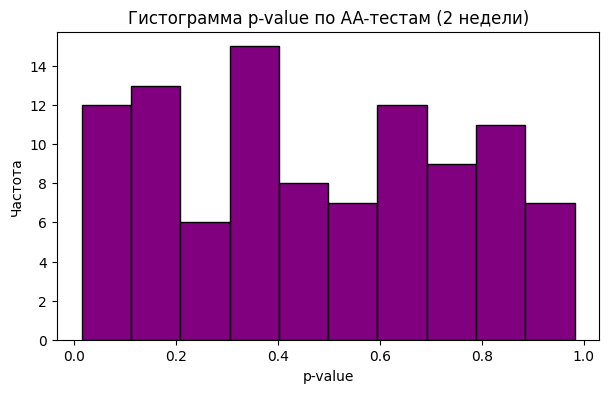

Сравнение корректности (AA-тест):
  - 1 неделя : 0.020
  - 2 недели: 0.040


In [25]:
p_values = [get_p_value(dist) for dist in values]

plt.figure(figsize=(7,4))
plt.hist(p_values, bins=10, color='purple', edgecolor='black')
plt.xlabel('p-value')
plt.ylabel('Частота')
plt.title('Гистограмма p-value по AA-тестам (2 недели)')
plt.show()

# Сравнение с результатом за 1 неделю

significance_aa_1w = 0.02
print(f"Сравнение корректности (AA-тест):")
print(f"  - 1 неделя : {significance_aa_1w:.3f}")
print(f"  - 2 недели: {significance_aa_2w:.3f}")

Из гистограммы видно, что p-value действительно разбросаны по всему диапазону. Да, есть некоторые всплески и провалы (что нормально для конечного числа итераций, тем более для 100), но в целом нет сильного смещения к крайним значениям (0 или 1).

На одной неделе тест даёт 2% ложных обнаружений эффекта то есть консервативен. На двух неделях ложных срабатываний немного больше (4%), но всё ещё в пределах разумных колебаний 5%. Это норм, потому что при большем объёме данных уменьшается роль «шумового» разброса, но иногда это приводит к более точному выявлению даже самых незначительных (и случайных) отклонений, и процент ложных срабатываний слегка растёт ближе к теоретическим 5%. В общем, вполне адекватно.

### Мощность

Теперь докинем эффект и посчитаем мощность. Для этого:
- подмешиваем эффект в B
- проводим бутстрап
- проверяем, попадает ли 0 в доверительный интервал
- Если 0 не попадает, мы обнаружили эффект (H_0 отвергается)
- Считаем долю таких срабатываний получаем мощность

По логике ожидаем, что при более крупном эффекте тест будет ловить разницу чаще (получаем мощность выше)

In [56]:
EFFECTS = [0.01, 0.03, 0.05]

In [26]:
results = {}

for effect in EFFECTS:
    power_list = []

    for _ in tqdm(range(N_ITERS), desc=f"Calc power, effect={effect*100}%"):
        salt = salt_generator()
        split_df = groups_splitter(
            df=last14_agg,
            columns=['user_id','total_dur','group'],
            user_salt=salt
        )

        vec_a = split_df.loc[split_df['group'] == 'A', 'total_dur'].values
        vec_b = split_df.loc[split_df['group'] == 'B', 'total_dur'].values

        vec_b_with_effect = vec_b * (1 + effect)

        sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
        sample_b_mean = calc_bootstrap_mean(vec_b_with_effect, size=1000)

        diff_array = sample_a_mean - sample_b_mean

        left_ci, right_ci = np.percentile(diff_array, [100*ALPHA/2, 100*(1-ALPHA/2)])

        found_diff = not (left_ci <= 0 <= right_ci)
        power_list.append(found_diff)

    power_value = sum(power_list) / len(power_list)
    results[effect] = power_value

for eff, pwr in results.items():
    print(f"Эффект {eff*100:.1f}% -> Мощность: {pwr:.3f} (т.е. ~{pwr*100:.2f}%)")

Calc power, effect=5.0%: 100%|██████████| 100/100 [14:27<00:00,  8.68s/it]

Эффект 1.0% -> Мощность: 0.150 (т.е. ~15.00%)
Эффект 3.0% -> Мощность: 0.530 (т.е. ~53.00%)
Эффект 5.0% -> Мощность: 0.960 (т.е. ~96.00%)


**Пояснение**:
- Для 1% эффекта за две недели мощность всего 15% (раньше за одну неделю было 22%). То есть при таком маленьком приросте тест редко “замечает” реальную разницу. Означает, что при эффекте 1% мы почти всегда не сможем доказать статистически значимое улучшение.
- Для 3% эффекта за две недели мощность уже 53%, а за одну неделю было аж 92%. Выходит, что при объединении данных за две недели мы почему-то хуже ловим 3-процентный эффект, скорее всего там увеличилась вариативность метрики, или различия внутри групп более шумные.
- А вот для 5% прироста за две недели мощность 96%, это очень хорошо: если прирост действительно 5%, мы почти всегда сможем его задетектить.

Вроде парадокс, что на двух неделях 3% эффект ловится хуже, чем на одной, но такое бывает когда метрика может «гулять» сильнее на более длинном периоде: у некоторых пользователей сильно выросли или упали просмотры, из-за чего дисперсия растет. А больше шума понижает вероятность заметить среднюю разницу.

### MDE

Осталось посчитать MDE. Для этого просто используем формулу с посчитанными квантилями нормального распределения. Теоретически можно логарифмировать, потому что исходные данные не нормальные. С другой стороны, их очень много, поэтому средние все равно будут распределены ближе к нормальному, даже при скошенном распределении. Поэтому оставим так.

In [57]:
import numpy as np
from scipy.stats import norm

def calculate_mde(metric_series, alpha, beta):
    """
    Рассчитывает MDE (в %) по формуле для z-test/t-test:
    MDE = (z_{alpha/2} + z_{beta}) * (std / sqrt(n)) * (100 / mean).
    """
    x = metric_series.dropna().values
    mean_val = np.mean(x)
    std_val = np.std(x, ddof=1)
    n = len(x)

    z_alpha  = norm.ppf(1 - alpha / 2)
    z_beta   = norm.ppf(1 - beta)

    mde_abs = (z_alpha + z_beta) * std_val / np.sqrt(n)

    mde_percent = mde_abs / mean_val * 100

    return mde_percent

In [28]:
alpha_emp = 0.04
beta_emp  = 0.47   # (1 - power) при условном эффекте 3%

mde_2w = calculate_mde(last14_agg['total_dur'], alpha_emp, beta_emp)

print(f"MDE (2 недели) при alpha={alpha_emp} и beta={beta_emp}: {mde_2w:.2f}%")

MDE (2 недели) при alpha=0.04 и beta=0.47: 1.43%


Получается при альфа=4% и бета=47% MDE в 1.43% означает что мы можем «уверенно» обнаружить эффект начиная примерно с 1.43% и больше на двух неделях. Если реальный прирост метрики будет меньше этого порога, наш тест с таким дизайном и таким большим β (то есть мощностью всего 53%) может его просто не заметить. Получается, что при эффекте ниже 1.43% мы почти наверняка не сможем доказать статистически значимое улучшение, зато если эффект больше, тест чаще всего сработает верно.

## Дизайн продолжение

In [29]:
N_ITERS = 50

### бутстреп + логарифмированная метрика длительности просмотров (4 балла)

In [59]:
last14_agg['total_dur_ln'] = np.log1p(last14_agg['total_dur'])

In [30]:
# last14_agg['total_dur_ln'] = np.log1p(last14_agg['total_dur'])

correctness = []
values = []

for _ in tqdm(range(N_ITERS), desc='AA-test: log metric'):
    salt = salt_generator()
    split_df = groups_splitter(
        df=last14_agg,
        columns=['user_id','total_dur_ln','group'],
        user_salt=salt
    ).copy()

    vec_a = split_df.loc[split_df['group'] == 'A', 'total_dur_ln'].values
    vec_b = split_df.loc[split_df['group'] == 'B', 'total_dur_ln'].values

    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    diff_array = sample_a_mean - sample_b_mean

    values.append(diff_array)

    left_ci, right_ci = np.percentile(diff_array, [100*ALPHA/2, 100*(1-ALPHA/2)])
    found_diff = not (left_ci <= 0 <= right_ci)
    correctness.append(found_diff)

test_correct_count = sum(correctness)
significance_log_aa = test_correct_count / len(correctness)

print(f"\n[AA-test] Логарифмированная метрика:")
print(f"Доля ложных срабатываний (significance) = {significance_log_aa:.4f}")

AA-test: log metric: 100%|██████████| 50/50 [07:22<00:00,  8.85s/it]


[AA-test] Логарифмированная метрика:
Доля ложных срабатываний (significance) = 0.0600


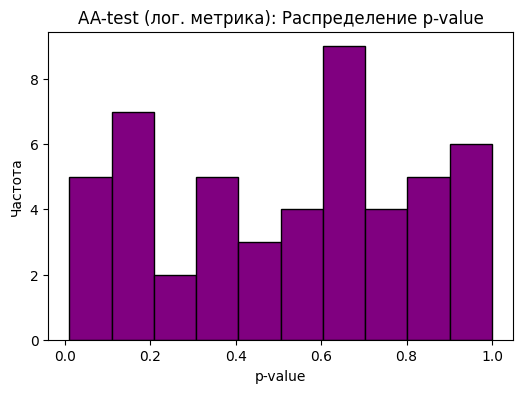

In [31]:
p_values = [get_p_value(diff) for diff in values]
plt.figure(figsize=(6,4))
plt.hist(p_values, bins=10, color='purple', edgecolor='black')
plt.title("AA-test (лог. метрика): Распределение p-value")
plt.xlabel("p-value")
plt.ylabel("Частота")
plt.show()

Вообще прибавлять процент к логарифмированной метрике — не то же самое, что умножать исходный total_dur на (1 + effect). Поэтому лучше имитировать эффект до логарифма. Т.е. восстановим "исходный" total_dur, докинем эффект, снова залогарифмируем

In [32]:
power_results = {}

for effect in EFFECTS:
    found_effect_list = []
    for _ in tqdm(range(N_ITERS), desc=f"Power log metric, effect={effect*100}%"):
        salt = salt_generator()
        split_df = groups_splitter(
            df=last14_agg,
            columns=['user_id','total_dur_ln','group'],
            user_salt=salt
        )

        vec_a = split_df.loc[split_df['group'] == 'A', 'total_dur_ln'].values
        vec_b = split_df.loc[split_df['group'] == 'B', 'total_dur_ln'].values

        real_b = np.expm1(vec_b)       # из log1p -> "исходная" total_dur
        real_b_with_eff = real_b * (1 + effect)
        vec_b_with_eff = np.log1p(real_b_with_eff)

        sample_a_mean = calc_bootstrap_mean(vec_a,  size=1000)
        sample_b_mean = calc_bootstrap_mean(vec_b_with_eff, size=1000)
        diff_array = sample_a_mean - sample_b_mean

        left_ci, right_ci = np.percentile(diff_array, [100*ALPHA/2, 100*(1-ALPHA/2)])
        found_effect_list.append(not (left_ci <= 0 <= right_ci))

    power_value = sum(found_effect_list) / len(found_effect_list)
    power_results[effect] = power_value

print("\n[Power test] Лог. метрика, эффекты 1/3/5% (условные):")
for eff, pwr in power_results.items():
    print(f"Эффект {eff*100:.1f}% -> Мощность: {pwr:.3f} (т.е. ~{pwr*100:.2f}%)")

Power log metric, effect=5.0%: 100%|██████████| 50/50 [07:26<00:00,  8.94s/it]


[Power test] Лог. метрика, эффекты 1/3/5% (условные):
Эффект 1.0% -> Мощность: 0.100 (т.е. ~10.00%)
Эффект 3.0% -> Мощность: 0.940 (т.е. ~94.00%)
Эффект 5.0% -> Мощность: 1.000 (т.е. ~100.00%)


In [33]:
alpha_emp = significance_log_aa
power_3p  = power_results[0.03]
beta_emp  = 1 - power_3p

mde_log = calculate_mde(last14_agg['total_dur_ln'], alpha_emp, beta_emp)

print(f"\n[MDE] Лог. метрика при alpha={alpha_emp:.3f} и beta={beta_emp:.3f}: {mde_log:.3f}%")
print("Внимание: это % относительно СРЕДНЕЙ log-метрики,")
print("а не процентов от самой total_dur в исходном масштабе.")


[MDE] Лог. метрика при alpha=0.060 и beta=0.060: 0.200%
Внимание: это % относительно СРЕДНЕЙ log-метрики,
а не процентов от самой total_dur в исходном масштабе.


### манна-уитни + метрика длительности просмотров (4 балла)

In [60]:
N_ITERS = 100
from scipy.stats import mannwhitneyu

In [36]:
correctness_mw = []
pvals_mw = []

for _ in tqdm(range(N_ITERS), desc='AA-test: Mann-Whitney'):
    salt = salt_generator()
    split_df = groups_splitter(
        df=last14_agg,
        columns=['user_id','total_dur','group'],
        user_salt=salt
    )

    vec_a = split_df.loc[split_df['group'] == 'A', 'total_dur'].values
    vec_b = split_df.loc[split_df['group'] == 'B', 'total_dur'].values

    # двусторонняя гипотеза
    stat, p_value = mannwhitneyu(vec_a, vec_b, alternative='two-sided')

    # Если p_value < alpha => отвергаем H0 => ложное срабатывание в AA-тесте
    found_diff = (p_value < ALPHA)
    correctness_mw.append(found_diff)
    pvals_mw.append(p_value)

significance_mw = np.mean(correctness_mw)

print(f"\n[AA-test] Mann–Whitney, исходная метрика total_dur:")
print(f"Доля ложных срабатываний (significance) = {significance_mw:.4f} (~{significance_mw*100:.2f}%)")

AA-test: Mann-Whitney: 100%|██████████| 100/100 [01:54<00:00,  1.15s/it]


[AA-test] Mann–Whitney, исходная метрика total_dur:
Доля ложных срабатываний (significance) = 0.0400 (~4.00%)


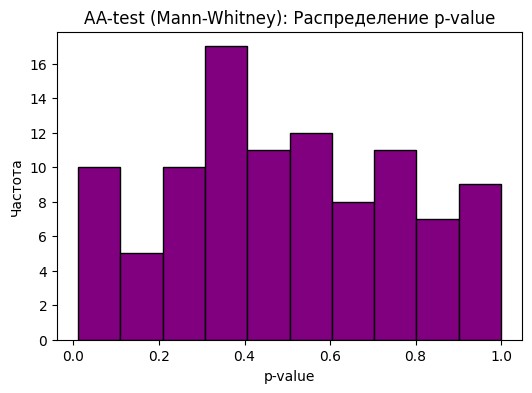

In [37]:
plt.figure(figsize=(6,4))
plt.hist(pvals_mw, bins=10, color='purple', edgecolor='black')
plt.title("AA-test (Mann-Whitney): Распределение p-value")
plt.xlabel("p-value")
plt.ylabel("Частота")
plt.show()

In [38]:
power_results_mw = {}

for effect in EFFECTS:
    found_diff_list = []
    for _ in tqdm(range(N_ITERS), desc=f"MW-power, effect={effect*100}%"):
        salt = salt_generator()
        split_df = groups_splitter(
            df=last14_agg,
            columns=['user_id','total_dur','group'],
            user_salt=salt
        )

        vec_a = split_df.loc[split_df['group'] == 'A', 'total_dur'].values
        vec_b = split_df.loc[split_df['group'] == 'B', 'total_dur'].values

        vec_b_effect = vec_b * (1 + effect)

        stat, p_value = mannwhitneyu(vec_a, vec_b_effect, alternative='two-sided')

        # Если p_value < alpha, считаем, что мы обнаружили эффект
        found_diff_list.append(p_value < ALPHA)

    power_value = np.mean(found_diff_list)
    power_results_mw[effect] = power_value

print("\n[Power test] Mann–Whitney + исходная метрика (total_dur):")
for eff, pwr in power_results_mw.items():
    print(f"Эффект {eff*100:.1f}% -> Мощность: {pwr:.3f} (~{pwr*100:.2f}%)")

MW-power, effect=5.0%: 100%|██████████| 100/100 [02:11<00:00,  1.31s/it]


[Power test] Mann–Whitney + исходная метрика (total_dur):
Эффект 1.0% -> Мощность: 0.160 (~16.00%)
Эффект 3.0% -> Мощность: 0.970 (~97.00%)
Эффект 5.0% -> Мощность: 1.000 (~100.00%)


Вот тут уже лучще не использовать прямую формулу для расчета MDE, поэтому будем делать иначе

In [43]:
def simulate_mde_mw(df, effect_range=None, alpha=0.05, target_power=0.8, iters=300):
    """
    Перебираем разные эффекты и считаем, при каком эффекте MW-тест достигает нужной мощности.
    df: датафрейм
    effect_range: список эффектов
    alpha: уровень значимости
    target_power: желаемая мощность (например, 0.8)
    iters: сколько раз повторяем случайное разбиение для оценки мощности

    Возвращает: (effect, power) - первый эффект, при котором power >= target_power
    """
    best_effect = None
    best_power  = 0.0

    for eff in effect_range:
        found_diff_list = []
        for _ in range(iters):
            salt = salt_generator()
            split_df = groups_splitter(
                df=df,
                columns=['user_id','total_dur','group'],
                user_salt=salt
            )

            vec_a = split_df.loc[split_df['group']=='A','total_dur'].values
            vec_b = split_df.loc[split_df['group']=='B','total_dur'].values

            vec_b_eff = vec_b * (1 + eff)

            stat, p_value = mannwhitneyu(vec_a, vec_b_eff, alternative='two-sided')
            found_diff_list.append(p_value < alpha)

        power_value = np.mean(found_diff_list)
        if power_value >= target_power:
            best_effect = eff
            best_power  = power_value
            break

    return best_effect, best_power

effect_values = np.arange(0.02, 0.051, 0.0025)
mde_effect, mde_power = simulate_mde_mw(
    df=last14_agg,
    effect_range=effect_values,
    alpha=0.05,
    target_power=0.8,   # хотим мощность 80% например
    iters=50
)

if mde_effect is None:
    print("Даже при 5% эффекте не достигли 80% мощности.")
else:
    print(f"\n[Empirical MDE for Mann–Whitney]")
    print(f"Первый эффект, при котором мощность >=80%: ~{mde_effect*100:.2f}% (мощность={mde_power*100:.1f}%)")


[Empirical MDE for Mann–Whitney]
Первый эффект, при котором мощность >=80%: ~2.50% (мощность=82.0%)


### манна-уитни + логарифмированная метрика длительности просмотров

In [62]:
from tqdm.notebook import tqdm

In [63]:
correctness_mw_log = []
pvals_mw_log = []

for _ in tqdm(range(N_ITERS), desc='AA-test: Mann–Whitney + log metric'):
    salt = salt_generator()
    split_df = groups_splitter(
        df=last14_agg,
        columns=['user_id','total_dur_ln','group'],
        user_salt=salt
    )

    vec_a = split_df.loc[split_df['group'] == 'A', 'total_dur_ln'].values
    vec_b = split_df.loc[split_df['group'] == 'B', 'total_dur_ln'].values

    stat, p_value = mannwhitneyu(vec_a, vec_b, alternative='two-sided')

    found_diff = (p_value < ALPHA)
    correctness_mw_log.append(found_diff)
    pvals_mw_log.append(p_value)

significance_mw_log = np.mean(correctness_mw_log)
print(f"\n[AA-test] Mann–Whitney + лог. метрика total_dur:")
print(f"Доля ложных срабатываний (significance) = {significance_mw_log:.4f} "
      f"(~{significance_mw_log*100:.2f}%)")

AA-test: Mann–Whitney + log metric:   0%|          | 0/100 [00:00<?, ?it/s]


[AA-test] Mann–Whitney + лог. метрика total_dur:
Доля ложных срабатываний (significance) = 0.0700 (~7.00%)


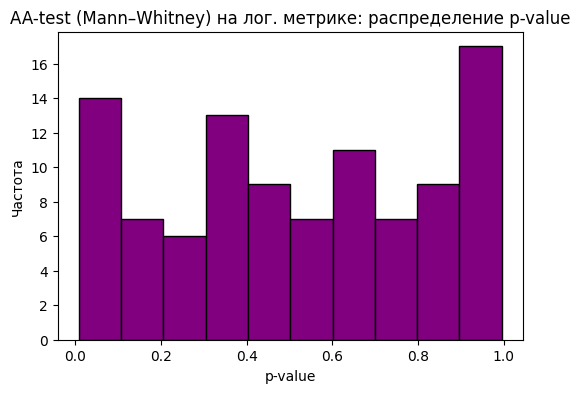

In [64]:
plt.figure(figsize=(6,4))
plt.hist(pvals_mw_log, bins=10, color='purple', edgecolor='black')
plt.title("AA-test (Mann–Whitney) на лог. метрике: распределение p-value")
plt.xlabel("p-value")
plt.ylabel("Частота")
plt.show()

In [65]:
power_results_mw_log = {}

for effect in EFFECTS:
    detect_list = []
    for _ in tqdm(range(N_ITERS), desc=f"MW+log power, effect={effect*100}%"):
        salt = salt_generator()
        split_df = groups_splitter(
            df=last14_agg,
            columns=['user_id','total_dur_ln','group'],
            user_salt=salt
        )

        vec_a = split_df.loc[split_df['group'] == 'A', 'total_dur_ln'].values
        vec_b = split_df.loc[split_df['group'] == 'B', 'total_dur_ln'].values

        real_b = np.expm1(vec_b)
        real_b_eff = real_b * (1 + effect)
        vec_b_with_eff = np.log1p(real_b_eff)

        stat, p_value = mannwhitneyu(vec_a, vec_b_with_eff, alternative='two-sided')

        detect_list.append(p_value < ALPHA)

    power_value = np.mean(detect_list)
    power_results_mw_log[effect] = power_value

print("\n[Power test] Mann–Whitney + лог. метрика, эффекты 1/3/5% (на исходной шкале):")
for eff, pwr in power_results_mw_log.items():
    print(f"Эффект {eff*100:.1f}% -> Мощность: {pwr:.3f} (т.е. ~{pwr*100:.2f}%)")

MW+log power, effect=1.0%:   0%|          | 0/100 [00:00<?, ?it/s]

MW+log power, effect=3.0%:   0%|          | 0/100 [00:00<?, ?it/s]

MW+log power, effect=5.0%:   0%|          | 0/100 [00:00<?, ?it/s]


[Power test] Mann–Whitney + лог. метрика, эффекты 1/3/5% (на исходной шкале):
Эффект 1.0% -> Мощность: 0.240 (т.е. ~24.00%)
Эффект 3.0% -> Мощность: 0.930 (т.е. ~93.00%)
Эффект 5.0% -> Мощность: 1.000 (т.е. ~100.00%)


In [67]:
def simulate_mde_mw_log(df, effect_values, alpha=0.05, target_power=0.8, iters=50):
    best_effect = None
    best_power  = 0.0

    for eff in effect_values:
        detect_list = []
        for _ in tqdm(range(iters)):
            salt = salt_generator()
            split_df = groups_splitter(
                df=df,
                columns=['user_id','total_dur_ln','group'],
                user_salt=salt
            )

            vec_a_ln = split_df.loc[split_df['group']=='A','total_dur_ln'].values
            vec_b_ln = split_df.loc[split_df['group']=='B','total_dur_ln'].values

            real_b   = np.expm1(vec_b_ln)
            real_b_e = real_b * (1 + eff)
            b_ln_e   = np.log1p(real_b_e)

            stat, p_value = mannwhitneyu(vec_a_ln, b_ln_e, alternative='two-sided')
            detect_list.append(p_value < alpha)

        power_value = np.mean(detect_list)
        if power_value >= target_power:
            best_effect = eff
            best_power  = power_value
            break

    return best_effect, best_power

effect_candidates = np.arange(0.0, 0.101, 0.0025)
mde_eff, mde_pow = simulate_mde_mw_log(
    df=last14_agg,
    effect_values=effect_candidates,
    alpha=0.05,
    target_power=0.8,
    iters=50
)

if mde_eff is None:
    print("Даже при 10% эффекте не дошли до 80% мощности :(")
else:
    print(f"\n[Empirical MDE] MW + лог. метрика:")
    print(f"Первый эффект = {mde_eff*100:.2f}% при котором мощность >=80% (фактическая: ~{mde_pow*100:.1f}%)")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


[Empirical MDE] MW + лог. метрика:
Первый эффект = 2.25% при котором мощность >=80% (фактическая: ~84.0%)


### t-test + метрика длительности просмотров (4 балла)

In [68]:
from scipy.stats import ttest_ind

correctness_tt = []
pvals_tt       = []

for _ in tqdm(range(N_ITERS), desc='AA-test: t-test + RAW metric'):
    salt = salt_generator()
    split_df = groups_splitter(
        df=last14_agg,
        columns=['user_id', 'total_dur', 'group'],
        user_salt=salt
    )

    vec_a = split_df.loc[split_df['group'] == 'A', 'total_dur'].values
    vec_b = split_df.loc[split_df['group'] == 'B', 'total_dur'].values

    stat, p_value = ttest_ind(vec_a, vec_b, equal_var=False)

    correctness_tt.append(p_value < ALPHA)
    pvals_tt.append(p_value)

significance_tt = np.mean(correctness_tt)

print(f"\n[AA-test] t-test на СЫРОЙ метрике (total_dur):")
print(f"Доля ложных срабатываний (significance) = {significance_tt:.4f} "
      f"(~{significance_tt*100:.2f}%)")

AA-test: t-test + RAW metric:   0%|          | 0/100 [00:00<?, ?it/s]


[AA-test] t-test на СЫРОЙ метрике (total_dur):
Доля ложных срабатываний (significance) = 0.0600 (~6.00%)


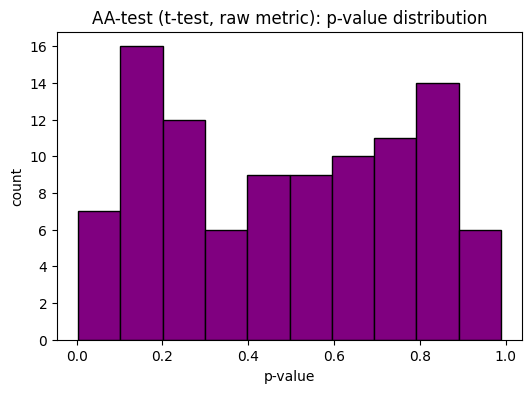

In [69]:
plt.figure(figsize=(6,4))
plt.hist(pvals_tt, bins=10, color='purple', edgecolor='black')
plt.title("AA-test (t-test, raw metric): p-value distribution")
plt.xlabel("p-value")
plt.ylabel("count")
plt.show()

In [70]:
power_results_tt = {}

for effect in EFFECTS:
    detect_list = []
    for _ in tqdm(range(N_ITERS), desc=f"Power test, effect={effect*100:.1f}%"):
        salt = salt_generator()
        split_df = groups_splitter(
            df=last14_agg,
            columns=['user_id','total_dur','group'],
            user_salt=salt
        )

        vec_a = split_df.loc[split_df['group'] == 'A', 'total_dur'].values
        vec_b = split_df.loc[split_df['group'] == 'B', 'total_dur'].values

        vec_b_eff = vec_b * (1 + effect)

        stat, p_value = ttest_ind(vec_a, vec_b_eff, equal_var=False)

        detect_list.append(p_value < ALPHA)

    power_value = np.mean(detect_list)
    power_results_tt[effect] = power_value

print("\n[Power test] t-test + RAW metric (total_dur):")
for eff, pwr in power_results_tt.items():
    print(f"  Эффект {eff*100:.1f}% -> Мощность: {pwr:.3f} (т.е. ~{pwr*100:.2f}%)")

Power test, effect=1.0%:   0%|          | 0/100 [00:00<?, ?it/s]

Power test, effect=3.0%:   0%|          | 0/100 [00:00<?, ?it/s]

Power test, effect=5.0%:   0%|          | 0/100 [00:00<?, ?it/s]


[Power test] t-test + RAW metric (total_dur):
  Эффект 1.0% -> Мощность: 0.120 (т.е. ~12.00%)
  Эффект 3.0% -> Мощность: 0.660 (т.е. ~66.00%)
  Эффект 5.0% -> Мощность: 0.900 (т.е. ~90.00%)


Тут опять можно просто по формуле

In [71]:
def calculate_mde(metric_series, alpha, beta):
    x = metric_series.dropna().values
    mean_val = np.mean(x)
    std_val  = np.std(x, ddof=1)
    n        = len(x)

    z_alpha = norm.ppf(1 - alpha / 2)
    z_beta  = norm.ppf(1 - beta)

    mde_abs = (z_alpha + z_beta) * std_val / np.sqrt(n)
    mde_percent = (mde_abs / mean_val) * 100
    return mde_percent

emp_alpha = significance_tt
emp_power_3 = power_results_tt[0.03]
emp_beta  = 1 - emp_power_3

mde_value = calculate_mde(last14_agg['total_dur'], emp_alpha, emp_beta)
print(f"\n[MDE] t-test + RAW metric:")
print(f"  alpha={emp_alpha:.3f}, beta={emp_beta:.3f} => MDE = {mde_value:.2f}% (от среднего total_dur)")


[MDE] t-test + RAW metric:
  alpha=0.060, beta=0.340 => MDE = 1.54% (от среднего total_dur)


### t-test + логарифмированная метрика длительности просмотров (4 балла)

In [72]:
# from scipy.stats import ttest_ind

correctness_tt_log = []
pvals_tt_log       = []

for _ in tqdm(range(N_ITERS), desc='AA-test: t-test + log-metric'):
    salt = salt_generator()
    split_df = groups_splitter(
        df=last14_agg,
        columns=['user_id', 'total_dur_ln', 'group'],
        user_salt=salt
    )

    vec_a = split_df.loc[split_df['group']=='A', 'total_dur_ln'].values
    vec_b = split_df.loc[split_df['group']=='B', 'total_dur_ln'].values

    stat, p_value = ttest_ind(vec_a, vec_b, equal_var=False)

    correctness_tt_log.append(p_value < ALPHA)
    pvals_tt_log.append(p_value)

significance_tt_log = np.mean(correctness_tt_log)

print(f"\n[AA-test] t-test + лог. метрика (total_dur_ln):")
print(f"Доля ложных срабатываний (significance) = {significance_tt_log:.4f} "
      f"(~{significance_tt_log*100:.2f}%)")

AA-test: t-test + log-metric:   0%|          | 0/100 [00:00<?, ?it/s]


[AA-test] t-test + лог. метрика (total_dur_ln):
Доля ложных срабатываний (significance) = 0.0400 (~4.00%)


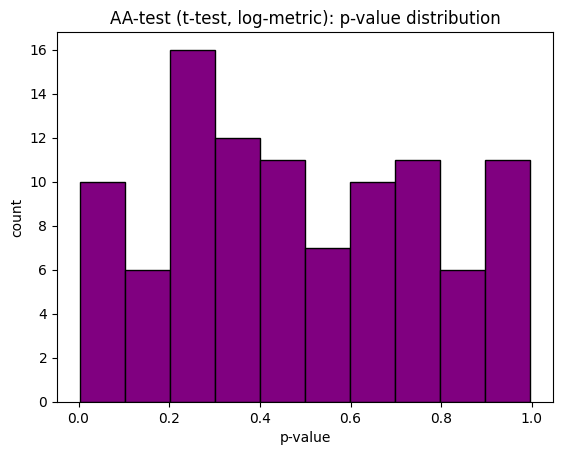

In [73]:
plt.hist(pvals_tt_log, bins=10, color='purple', edgecolor='black')
plt.title("AA-test (t-test, log-metric): p-value distribution")
plt.xlabel("p-value")
plt.ylabel("count")
plt.show()

In [74]:
power_results_tt_log = {}

for effect in EFFECTS:
    detect_list = []
    for _ in tqdm(range(N_ITERS), desc=f"Power test, effect={effect*100:.1f}% on LOG"):
        salt = salt_generator()
        split_df = groups_splitter(
            df=last14_agg,
            columns=['user_id','total_dur_ln','group'],
            user_salt=salt
        )

        vec_a_ln = split_df.loc[split_df['group'] == 'A', 'total_dur_ln'].values
        vec_b_ln = split_df.loc[split_df['group'] == 'B', 'total_dur_ln'].values

        real_b   = np.expm1(vec_b_ln)
        real_b_e = real_b * (1 + effect)
        vec_b_eff_ln = np.log1p(real_b_e)

        stat, p_value = ttest_ind(vec_a_ln, vec_b_eff_ln, equal_var=False)
        detect_list.append(p_value < ALPHA)

    power_value = np.mean(detect_list)
    power_results_tt_log[effect] = power_value

print("\n[Power test] t-test + ЛОГ. метрика, эффекты 1/3/5% (на исходной шкале):")
for eff, pwr in power_results_tt_log.items():
    print(f"  Эффект {eff*100:.1f}% -> Мощность: {pwr:.3f} (т.е. ~{pwr*100:.2f}%)")

Power test, effect=1.0% on LOG:   0%|          | 0/100 [00:00<?, ?it/s]

Power test, effect=3.0% on LOG:   0%|          | 0/100 [00:00<?, ?it/s]

Power test, effect=5.0% on LOG:   0%|          | 0/100 [00:00<?, ?it/s]


[Power test] t-test + ЛОГ. метрика, эффекты 1/3/5% (на исходной шкале):
  Эффект 1.0% -> Мощность: 0.210 (т.е. ~21.00%)
  Эффект 3.0% -> Мощность: 0.840 (т.е. ~84.00%)
  Эффект 5.0% -> Мощность: 1.000 (т.е. ~100.00%)


In [75]:
def calculate_mde_log(metric_series, alpha, beta):
    """
    MDE = (z_{alpha/2} + z_beta) * (std / sqrt(n)) * (100 / mean).
    Здесь mean и std считаются от LOG-метрики!
    Возвращаем % относительно средней log-метрики.
    """
    x = metric_series.dropna().values
    mean_val = np.mean(x)
    std_val  = np.std(x, ddof=1)
    n        = len(x)

    from scipy.stats import norm
    z_alpha = norm.ppf(1 - alpha/2)
    z_beta  = norm.ppf(1 - beta)

    mde_abs = (z_alpha + z_beta) * std_val / np.sqrt(n)
    mde_percent = (mde_abs / mean_val) * 100
    return mde_percent

emp_alpha_log = significance_tt_log
emp_power_3   = power_results_tt_log[0.03]
emp_beta_log  = 1 - emp_power_3

mde_log_value = calculate_mde_log(last14_agg['total_dur_ln'], emp_alpha_log, emp_beta_log)
print(f"\n[MDE] t-test + лог. метрика:")
print(f"  alpha={emp_alpha_log:.3f}, beta={emp_beta_log:.3f} => MDE = {mde_log_value:.2f}% (в лог-пространстве)")


[MDE] t-test + лог. метрика:
  alpha=0.040, beta=0.160 => MDE = 0.18% (в лог-пространстве)


### Выводы

Наши данные очень скошены. В такой ситуации t-test и другие методы, которые расчитаны на приблизительную нормальность, могут «шуметь». Логарифмирование делает распределение более «компактным» и сглаживает хвост, хотя всё равно не идеально нормирует данные, но явно лучше, чем было.

- Бутстрап + логарифм: довольно адекватен, даёт 6% ложных срабатываний (чуть больше 5%), и мощность при 3% эффекте — 94%. MDE получился 0.2% в лог-пространстве, что указывает на высокую чувствительность. С бутстрапом вообще хорошо — бутстрап менее чувствителен к ненормальности, но при этом логирование уменьшает дисперсию, что повышает мощность.

- Манна-Уитни + сырая метрика: всего 4% ложных срабатываний, и при 3% эффекте 97% мощность. Но из-за сильной скошенности метрики он может дать нестабильное поведение, хотя тут вроде цифры хороши. MDE около 2.5%. Формально должен хорошо работать при любых распределениях, тут он показал даже 97% мощность на 3% эффект. Но иногда при очень тяжёлом хвосте и множественных повторах (нулевые значения) он может перестать быть чувствительным. В данных результах всё ок, но логарифмирование может усилить стабильность.

- Манна-Уитни + лог-метрика: 7% ложных срабатываний (чуть выше классических 5%), 93% мощность на 3% эффекте и MDE примерно 2.25%. Подходит, но возможно чуть «переливает».

- t-test + сырая метрика: 6% ложных срабатываний, при 3% эффекте мощность лишь 66%, что не так уж высоко. MDE порядка 1.54% (по сути, ловим только эффекты >1.5%). не очень подходит, поскольку распределение очень сильно скошено, и это приводит к низкой мощности

- t-test + лог-метрика: 4% ложных срабатываний, 84% мощность при 3% эффекте, MDE = 0.18% в лог-шкале. Это показывает, что логировать метрику явно помогает t-тесту (получаем более высокую мощность на том же эффекте).Логарифмирование «выравнивает» метрику, позволяя t-test (который рассчитан на более-менее нормальное распределение средних) работать корректнее.

С точки зрения баланса «простота анализа + мощность + привычность», я бы выбрала t-test + логарифмированная метрика. Получаем достаточно ровное распределение, 84% мощность на 3% эффекте, MDE 0.18% в лог-пространстве (что примерно соответствует ~1-1.5% приросту на исходной шкале, хотя точный перевод надо аккуратно считать).

Также бутстрап или Манна-Уитни + лог могут дать ещё более высокую мощность, но они чуть сложнее в интерпретации и реализции, и иногда медленнее (бутстрап).

## A/B тест

In [76]:
last14_agg_mod = last14_agg.copy()
last14_agg_mod.loc[last14_agg_mod['total_dur'] < 500, 'total_dur'] = 0

print("Пользователи с total_dur=0:", (last14_agg_mod['total_dur'] == 0).sum())
print("Всего строк:", last14_agg_mod.shape[0])

Пользователи с total_dur=0: 51093
Всего строк: 266081


In [77]:
salt = "kiontestmodel20210805"

ab_df = groups_splitter(
    df=last14_agg_mod,
    columns=['user_id','total_dur','group'],
    user_salt=salt
)

print(ab_df.head())
print(ab_df.groupby('group')['user_id'].count())

   user_id  total_dur group
0        1      21172     B
1        3      64654     B
2        9          0     A
3       12       5929     B
4       14      10324     A
group
A    133608
B    132473
Name: user_id, dtype: int64


In [81]:
test_df = ab_df.copy()

b_mask = (test_df['group'] == 'B')

threshold = test_df.loc[b_mask, 'total_dur'].quantile(0.90)
print(f"90%-квантиль группы B: {threshold:.1f}")

heavy_b_mask = b_mask & (test_df['total_dur'] > threshold)

test_df.loc[heavy_b_mask, 'total_dur'] *= 1.025

non_heavy_b_mask = b_mask & (~heavy_b_mask)

# Генерируем небольшой случайный эффект (скажем, от +0% до +1%)
random_effects = np.random.uniform(low=0.0, high=0.01, size=non_heavy_b_mask.sum())
idx_non_heavy = test_df.loc[non_heavy_b_mask].index
test_df.loc[idx_non_heavy, 'total_dur'] *= (1 + random_effects)

print(f"Добавлен эффект:\n  - {heavy_b_mask.sum()} heavy-пользователей: +2.5%\n  - {non_heavy_b_mask.sum()} остальных: случайный эффект до +1%")

90%-квантиль группы B: 47006.0
Добавлен эффект:
  - 13247 heavy-пользователей: +2.5%
  - 119226 остальных: случайный эффект до +1%


<ipython-input-81-430fed7beb4e>:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 66270.35   99197.45   87342.3   ... 248961.225  50740.575  63301.95 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_df.loc[heavy_b_mask, 'total_dur'] *= 1.025


In [82]:
res = test_df.groupby('group')['total_dur'].mean().reset_index()
mean_a = res.loc[res['group']=='A','total_dur'].values[0]
mean_b = res.loc[res['group']=='B','total_dur'].values[0]
lift   = (mean_b / mean_a - 1) * 100

print("\nСредняя total_dur (с докинутым эффектом):")
print(res)
print(f"Лифт (B vs A): {lift:.2f}%")


Средняя total_dur (с докинутым эффектом):
  group     total_dur
0     A  21391.220346
1     B  21757.093168
Лифт (B vs A): 1.71%


In [84]:
import numpy as np
from scipy.stats import ttest_ind

test_df['total_dur_ln'] = np.log1p(test_df['total_dur'])

vec_a_ln = test_df.loc[test_df['group'] == 'A', 'total_dur_ln'].values
vec_b_ln = test_df.loc[test_df['group'] == 'B', 'total_dur_ln'].values

stat, p_value = ttest_ind(vec_a_ln, vec_b_ln, equal_var=False)

mean_a = np.mean(vec_a_ln)
mean_b = np.mean(vec_b_ln)
lift_ln = (mean_b - mean_a) / abs(mean_a) * 100

print("=== t-test + логарифмированная метрика (после всех манипуляций) ===")
print(f"Размер группы A: {len(vec_a_ln)}, группа B: {len(vec_b_ln)}")
print(f"Среднее log(total_dur+1) в группе A = {mean_a:.3f}")
print(f"Среднее log(total_dur+1) в группе B = {mean_b:.3f}")
print(f"Лифт в лог-пространстве: {lift_ln:.2f}%")
print(f"t-stat={stat:.4f}, p-value={p_value:.6f}")

if p_value < 0.05:
    print("Есть статистически значимое отличие (p<0.05). Группа B лучше в лог-пространстве.")
else:
    print("Статистически значимых отличий не обнаружено (p>=0.05).")

=== t-test + логарифмированная метрика (после всех манипуляций) ===
Размер группы A: 133608, группа B: 132473
Среднее log(total_dur+1) в группе A = 7.318
Среднее log(total_dur+1) в группе B = 7.349
Лифт в лог-пространстве: 0.42%
t-stat=-2.0747, p-value=0.038015
Есть статистически значимое отличие (p<0.05). Группа B лучше в лог-пространстве.


**С вероятностью 95% и выше можно отвергнуть гипотезу «B не отличается от A».**

Разница в лог-шкале: у нас получился лифт ~0.42%. В лог-пространстве это не напрямую «+0.42% к исходной длительности», а означает, что при «развороте» через экспоненту прирост на исходной шкале может быть чуть выше (в районе полупроцента или около того).

Эффект в 0.4–0.5% не кажется большим, но если аудитория огромна, даже небольшой процент даёт существенный прирост. Кроме того, мы специально докинули эффект только части пользователей (heavy users, плюс случайный эффект остальным), поэтому реальное «среднее улучшение» может быть близко к тому, что мы хотели проверить (вроде 2.5% у топ-10%, до 1% у остальных).